In [3]:
import numpy as np
import pandas as pd 
import re
import matplotlib.pyplot as plt
from pyfaidx import Fasta
import os


In [24]:
prob_merge = pd.read_csv('/work4/home/guanjun/DM_human/20251017_TBS_mapping/mapping_table/analysis/20251219_prob_merge_with_seq.csv',sep='\t')

In [5]:
def revcomp(seq):
    comp = str.maketrans("ACGTN", "TGCAN")
    return seq.translate(comp)[::-1]

In [6]:
genome = Fasta("genome.fa")   # 換成你的 fasta 路徑

In [7]:
def check_probe_with_genome(prob_merge):
    records = []

    for _, r in prob_merge.iterrows():
        chrom = r["chr"]
        start = int(r["start"])   # 假設 BED 0-based
        end   = int(r["end"])
        seq   = r["seq"].upper()

        genome_seq = str(genome[chrom][start:end]).upper()
        seq_rc = revcomp(seq)

        if genome_seq == seq:
            strand = "+"
            ok = True
        elif genome_seq == seq_rc:
            strand = "-"
            ok = True
        else:
            strand = "?"
            ok = False

        records.append({
            "probe_key": r["key"],
            "chr": chrom,
            "start": start,
            "end": end,
            "strand": strand,
            "match": ok
        })

    return pd.DataFrame(records)

In [8]:
probe_check_df = check_probe_with_genome(prob_merge)

probe_check_df["strand"].value_counts()
probe_check_df["match"].value_counts()

match
True    6971
Name: count, dtype: int64

Make the table of depth of all CpG sites from libraries across all prob CpG sites

In [14]:
cpg_tab = pd.read_csv("probe_CpG_CG_table.tsv", sep="\t")

# CGmap 的 pos 是 1-based（你前面表格 pos_1based 就是對的）
cpg_tab["site_key"] = (
    cpg_tab["chr"].astype(str) + ":" +
    cpg_tab["pos_1based"].astype(str) + ":" +
    cpg_tab["base"].astype(str)      # C 或 G，要跟 CGmap col2 對齊
)

wanted_keys = set(cpg_tab["site_key"])
col_order = cpg_tab["label"].tolist()
label2key = dict(zip(cpg_tab["label"], cpg_tab["site_key"]))

In [15]:
def extract_cov_from_cgmap_bsseeker2(cgmap_path, wanted_keys, chunksize=2_000_000):
    """
    回傳 dict: site_key('chr:pos:base') -> coverage(#C+#T)
    """
    colnames = ["chr", "base", "pos", "context", "dinuc", "mlevel", "nC", "covCT"]

    site2cov = {}

    reader = pd.read_csv(
        cgmap_path,
        sep="\t",
        header=None,
        names=colnames,
        compression="infer",          # 直接支援 .gz
        usecols=[0, 1, 2, 3, 7],       # 只讀 chr, base, pos, context, covCT
        dtype={0: str, 1: str, 2: int},
        chunksize=chunksize
    )

    for chunk in reader:
        chunk.columns = ["chr", "base", "pos", "context", "covCT"]

        # 只要 CpG context（你需求是 CpG site）
        chunk = chunk[chunk["context"] == "CG"]
        if chunk.empty:
            continue

        chunk["site_key"] = (
            chunk["chr"].astype(str) + ":" +
            chunk["pos"].astype(str) + ":" +
            chunk["base"].astype(str).str.upper()
        )

        sub = chunk[chunk["site_key"].isin(wanted_keys)]
        if sub.empty:
            continue

        cov = pd.to_numeric(sub["covCT"], errors="coerce").fillna(0).astype(int)

        for k, v in zip(sub["site_key"], cov):
            # 通常不會重複；保險起見用 max 或加總都可。這裡用 max。
            prev = site2cov.get(k, None)
            site2cov[k] = int(v) if prev is None else max(prev, int(v))

    return site2cov

In [16]:
import os

def build_reads_matrix_from_cgmap(cgmap_files, wanted_keys, col_order, label2key):
    lib_names = [os.path.basename(p).split(".")[0] for p in cgmap_files]

    # 用 Int64 比較安全（nullable int）
    mat = pd.DataFrame(index=lib_names, columns=col_order, dtype="Int64")

    for lib, path in zip(lib_names, cgmap_files):
        site2cov = extract_cov_from_cgmap_bsseeker2(path, wanted_keys)

        mat.loc[lib, :] = [
            site2cov.get(label2key[label], 0)
            for label in col_order
        ]

    return mat

In [20]:
cgmap_files = [
    "/work3/guanjun/temp/tbs_test/test_fullReads/SGLTiFU-140_V3_hg19_PE.out.CGmap.gz",
    "/work3/guanjun/temp/tbs_test/test_fullReads/SGLTiFU-143_V1_hg19_PE.out.CGmap.gz",
    "/work3/guanjun/temp/tbs_test/test_fullReads/SGLTiFU-148_V1_hg19_PE.out.CGmap.gz",
    # 其他 libraries 依序加進來...
]

reads_matrix = build_reads_matrix_from_cgmap(cgmap_files, wanted_keys, col_order, label2key)
reads_matrix.to_csv("library_by_probeCpG_reads.tsv", sep="\t", index=True)

In [4]:
reads_matrix=pd.read_csv("library_by_probeCpG_reads.tsv", sep="\t", index_col=0)

In [5]:
reads_matrix.head()

,M0002|CpG001|C,M0002|CpG001|G,M0002|CpG002|C,M0002|CpG002|G,M0002|CpG003|C,M0002|CpG003|G,M0002|CpG004|C,M0002|CpG004|G,M0002|CpG005|C,M0002|CpG005|G,...,M8692|CpG003|C,M8692|CpG003|G,M8692|CpG004|C,M8692|CpG004|G,M8694|CpG001|C,M8694|CpG001|G,M8694|CpG002|C,M8694|CpG002|G,M8695|CpG001|C,M8695|CpG001|G
SGLTiFU-140_V3_hg19_PE,8,45,6,39,8,19,5,18,5,19,...,261,361,214,276,373,227,357,245,356,335
SGLTiFU-143_V1_hg19_PE,2,5,2,5,1,5,1,2,1,2,...,103,117,89,93,182,110,193,110,195,207
SGLTiFU-148_V1_hg19_PE,9,28,8,26,6,20,6,17,4,17,...,85,69,78,64,0,0,0,0,0,0


In [15]:
# print the the max and min value across all table and print the col name of the max value
print("Max coverage:", reads_matrix.max().max())
print("Column of max coverage:", reads_matrix.stack().idxmax()[1])

Max coverage: 2439
Column of max coverage: M0132|CpG006|G


In [20]:
# count how many columns all 0 in three rows of reads_matrix
zero_counts = (reads_matrix.loc[["SGLTiFU-140_V3_hg19_PE", "SGLTiFU-143_V1_hg19_PE", "SGLTiFU-148_V1_hg19_PE"]].sum(axis=0) == 0).sum()
print(zero_counts)
over4_counts = (reads_matrix.loc[["SGLTiFU-140_V3_hg19_PE", "SGLTiFU-143_V1_hg19_PE", "SGLTiFU-148_V1_hg19_PE"]].sum(axis=0) >= 4).sum()
print(over4_counts) # 這個是加總>=4的數量，不是我要的每個都>=4的數量

libs = [
    "SGLTiFU-140_V3_hg19_PE",
    "SGLTiFU-143_V1_hg19_PE",
    "SGLTiFU-148_V1_hg19_PE"
]

# 每個 library 都 >= 4
all_over4_counts = (
    reads_matrix.loc[libs] >= 4
).all(axis=0).sum()

print(all_over4_counts)

196
61596
59344


In [22]:
#print the rows of zero_counts CpG from the reads matrix
zero_cpgs = reads_matrix.columns[
    (reads_matrix.loc[["SGLTiFU-140_V3_hg19_PE", "SGLTiFU-143_V1_hg19_PE", "SGLTiFU-148_V1_hg19_PE"]].sum(axis=0) == 0)
]
print(zero_cpgs)


Index(['M0002|CpG012|C', 'M0002|CpG013|C', 'M0002|CpG014|C', 'M0012|CpG001|C',
       'M0015|CpG004|G', 'M0237|CpG007|G', 'M0237|CpG008|G', 'M0243|CpG001|C',
       'M0243|CpG002|C', 'M0306|CpG001|C',
       ...
       'M7955|CpG003|G', 'M7955|CpG004|G', 'M7955|CpG005|G', 'M7955|CpG006|G',
       'M7955|CpG007|G', 'M8294|CpG001|G', 'M8294|CpG002|G', 'M8315|CpG017|C',
       'M8315|CpG018|C', 'M8315|CpG019|C'],
      dtype='object', length=196)


In [26]:
zero_df = pd.DataFrame({"label": zero_cpgs})
zero_df["probe_id"] = zero_df["label"].str.split("|").str[0]
probe_len_map = (
    prob_merge[["Mx_list", "length"]]
    .drop_duplicates()
    .set_index("Mx_list")["length"]
)
zero_df["probe_length"] = zero_df["probe_id"].map(probe_len_map)
zero_probe_counts = zero_df["probe_id"].value_counts()
print(zero_probe_counts.head(10))
zero_df["probe_length"].hist()

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

Missing length: 0
probe_id
M6851,M6852,M6850    19
M7644                16
M4306,M4307          16
M2653                12
M6397                10
M4305                 9
M1915                 8
M6479                 8
M7955                 7
M3760                 7
Name: count, dtype: int64


<Axes: >

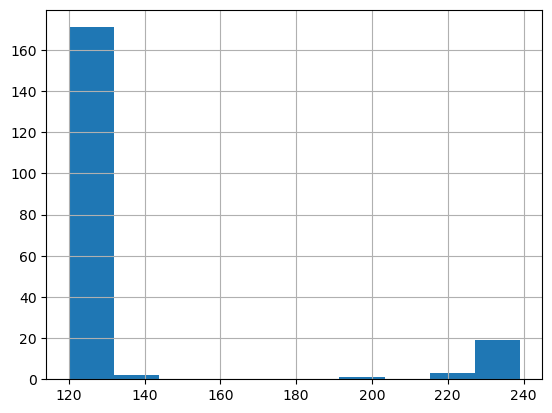

In [27]:
import pandas as pd

zero_df = pd.DataFrame({"label": list(zero_cpgs)})
zero_df["probe_id"] = zero_df["label"].str.split("|").str[0]

# 讓每個 Mx_list 只對應到一個 length
probe_len_map = prob_merge.groupby("Mx_list")["length"].first()

zero_df["probe_length"] = zero_df["probe_id"].map(probe_len_map)

# 看哪些 probe_id 沒對到（如果有的話）
print("Missing length:", zero_df["probe_length"].isna().sum())

zero_probe_counts = zero_df["probe_id"].value_counts()
print(zero_probe_counts.head(10))

zero_df["probe_length"].hist()

plot the result

In [6]:
libs = [
    "SGLTiFU-140_V3_hg19_PE",
    "SGLTiFU-143_V1_hg19_PE",
    "SGLTiFU-148_V1_hg19_PE"
]

sub = reads_matrix.loc[libs]

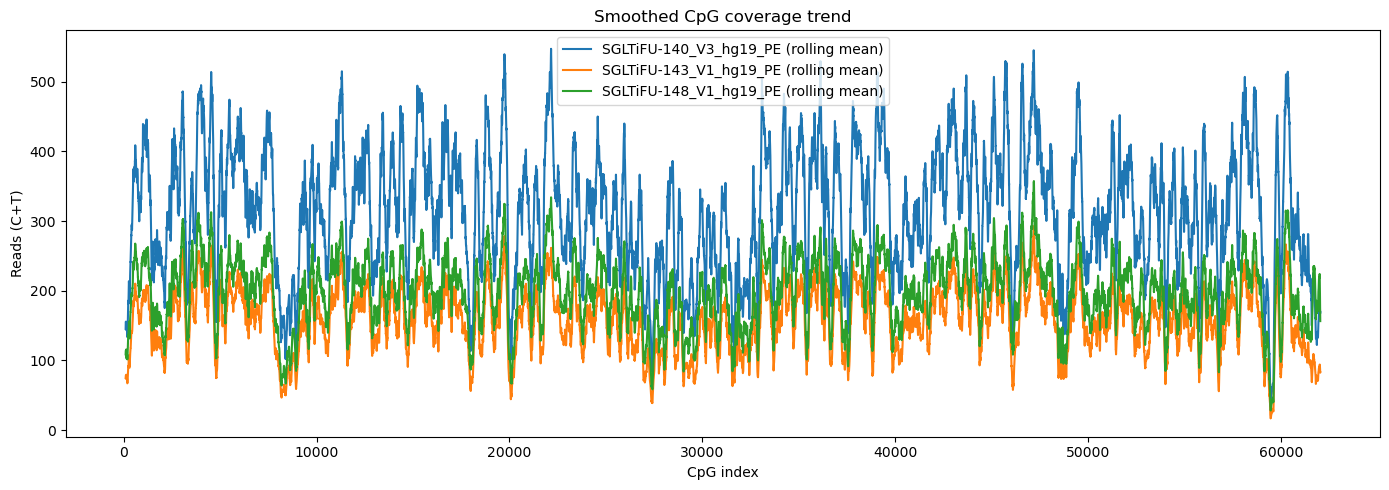

In [7]:
plt.figure(figsize=(14, 5))

window = 200  # 平滑視窗大小

for lib in libs:
    y = pd.Series(sub.loc[lib].values).rolling(window, center=True).mean()
    plt.plot(y, label=f"{lib} (rolling mean)")

plt.xlabel("CpG index")
plt.ylabel("Reads (C+T)")
plt.title("Smoothed CpG coverage trend")
plt.legend()
plt.tight_layout()
plt.show()

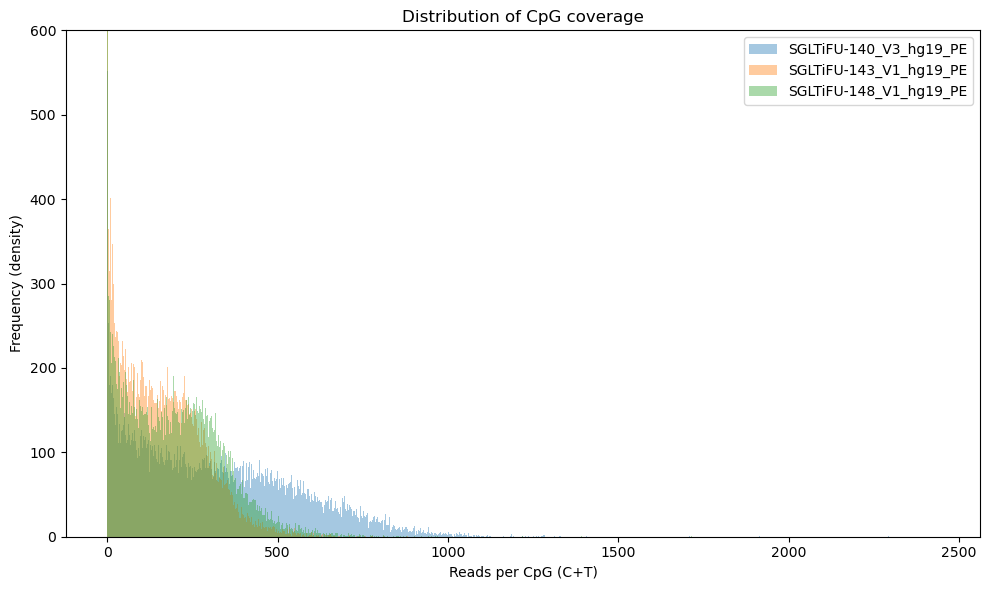

In [17]:
plt.figure(figsize=(10, 6))

bins = np.arange(0, sub.values.max() + 2)

for lib in libs:
    plt.hist(
        sub.loc[lib].values,
        bins=bins,
        alpha=0.4,
        label=lib,
        density=False   # ← 很重要，讓不同樣本可比較
    )

plt.xlabel("Reads per CpG (C+T)")
plt.ylabel("Frequency (density)")
plt.title("Distribution of CpG coverage")
#set the y axis range
plt.ylim(0, 600)
plt.legend()
plt.tight_layout()
plt.show()

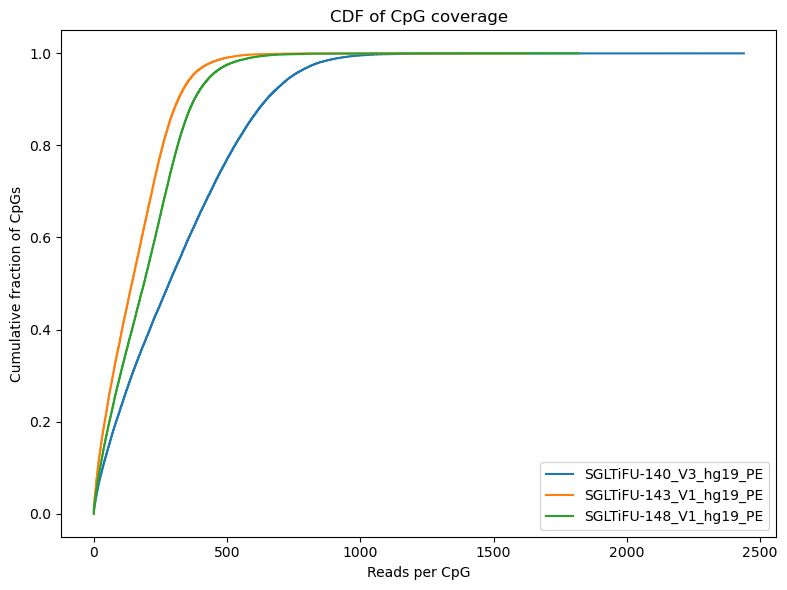

In [9]:
plt.figure(figsize=(8,6))

for lib in libs:
    x = np.sort(sub.loc[lib].values)
    y = np.arange(1, len(x)+1) / len(x)
    plt.plot(x, y, label=lib)

plt.xlabel("Reads per CpG")
plt.ylabel("Cumulative fraction of CpGs")
plt.title("CDF of CpG coverage")
plt.legend()
plt.tight_layout()
plt.show()